In [1]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops

In [2]:
time_multiplicator = 1
seed = 244810
samples = 2410

In [3]:
def vis(net,out, name):
    fig, axs = plt.subplots(2, 2,figsize=(14,14))

    mycmap = "coolwarm"
    minv = np.min(X_train)+np.min(X_train)/10
    maxv = np.max(X_train)+np.max(X_train)/10
    mesh = np.meshgrid(np.arange(minv, maxv, 0.1), np.arange(minv, maxv, 0.1))[0]
    my_predict = np.array(net.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)


    # my_predict = np.round(my_predict)
    axs[0,0].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].contour(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="o", alpha=0.5,cmap=mycmap)
    axs[0,0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="+", alpha=0.2,cmap=mycmap)

    my_cm = metrics.confusion_matrix(y_test, np.round(out).reshape(X_test.shape[0]))
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[0,1] ,cmap="plasma")
    # my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')


    fpr, tpr, thresholds = metrics.roc_curve(y_test,  np.round(net.predict(X_test)).reshape(X_test.shape[0]))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[1,0])

    axs[1,1].plot(net.errors)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('Accuracy')


    print(name)
    print(f'Czułość       |{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
    print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(np.round(out), y_test):9.4f}')
    print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')

In [4]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def __repr__(self):
        return(f"{self.__class__.__name__}")

In [5]:
class Linear(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) 
        self.bias = np.random.rand(1, output_size) 

    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error
        

In [6]:
class Activation(Layer):
    def __init__(self):
        self.activation = self.logistic
        self.activation_der = self.logistic_der
        
    def logistic(self, X):
        return  1.0/(1+np.exp(-X))
    
    def logistic_der(self, X):
        return self.logistic(X) * (1-self.logistic(X))
    
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.activation_der(self.input) * output_error

In [7]:
from tqdm import tqdm

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.errors = []

    def add(self, layer):
        self.layers.append(layer)
        
    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)
        # training loop
        for i in tqdm(range(epochs)):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward(error, learning_rate)

            # calculate average error on all samples
            self.errors.append(err / samples)
        # plt.plot(self.errors)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.20it/s]


Sieć 2-warstwowa, 4 neurony warstwy ukrytej
Czułość       |   0.9918
Specyficzność |   0.9916
Skuteczność   |   0.9917
BACC          |   0.9917


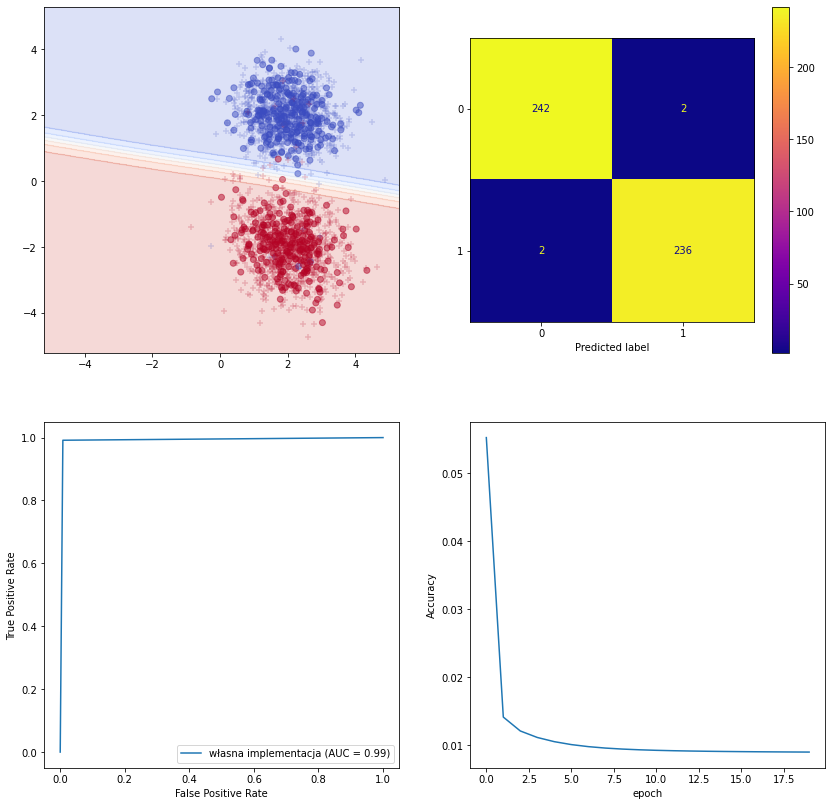

In [8]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network()
net.add(Linear(2, 4))
net.add(Activation())
net.add(Linear(4, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)


# train
net.use(mse, mse_prime)
net.fit(X_train_new, y_train, epochs=20, learning_rate=0.1)

# test
out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])
vis(net,out, 'Sieć 2-warstwowa, 4 neurony warstwy ukrytej')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


Sieć 3-warstwowa, 16 neuronów warstw ukrytych
Czułość       |   0.9870
Specyficzność |   0.9484
Skuteczność   |   0.9668
BACC          |   0.9677


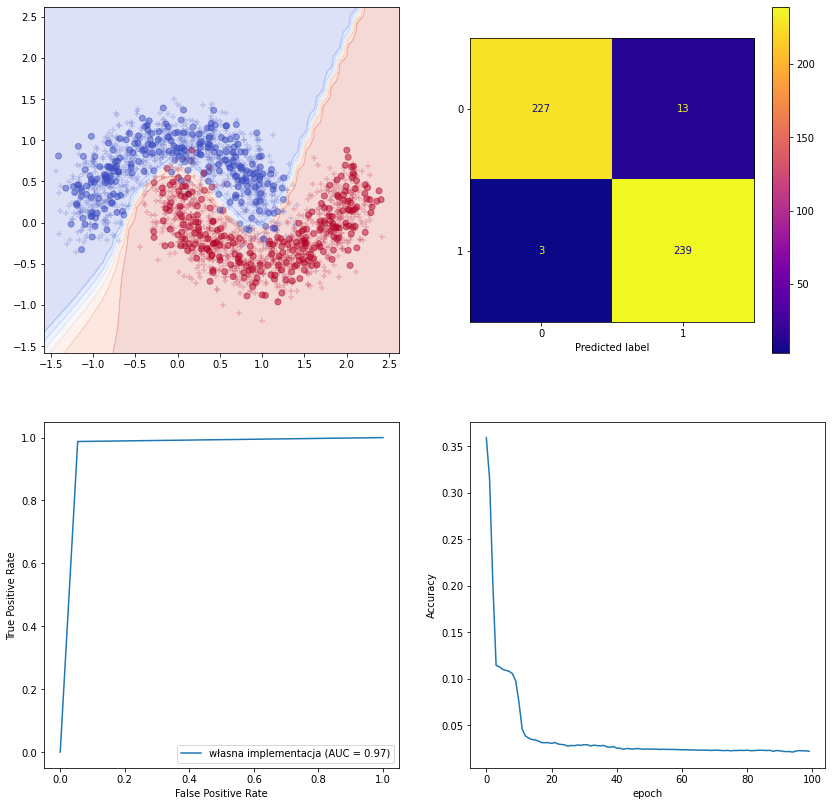

In [9]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.2, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

net = Network()
net.add(Linear(2, 16))
net.add(Activation())
net.add(Linear(16, 16))
net.add(Activation())
net.add(Linear(16, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)


# train
net.use(mse, mse_prime)
net.fit(X_train_new, y_train, epochs=100, learning_rate=0.3)

# test
out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])
vis(net,out, 'Sieć 3-warstwowa, 16 neuronów warstw ukrytych')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.37it/s]


Sieć 3-warstwowa, 16 neuronów warstw ukrytych
Czułość       |   0.8765
Specyficzność |   0.8870
Skuteczność   |   0.8817
BACC          |   0.8818


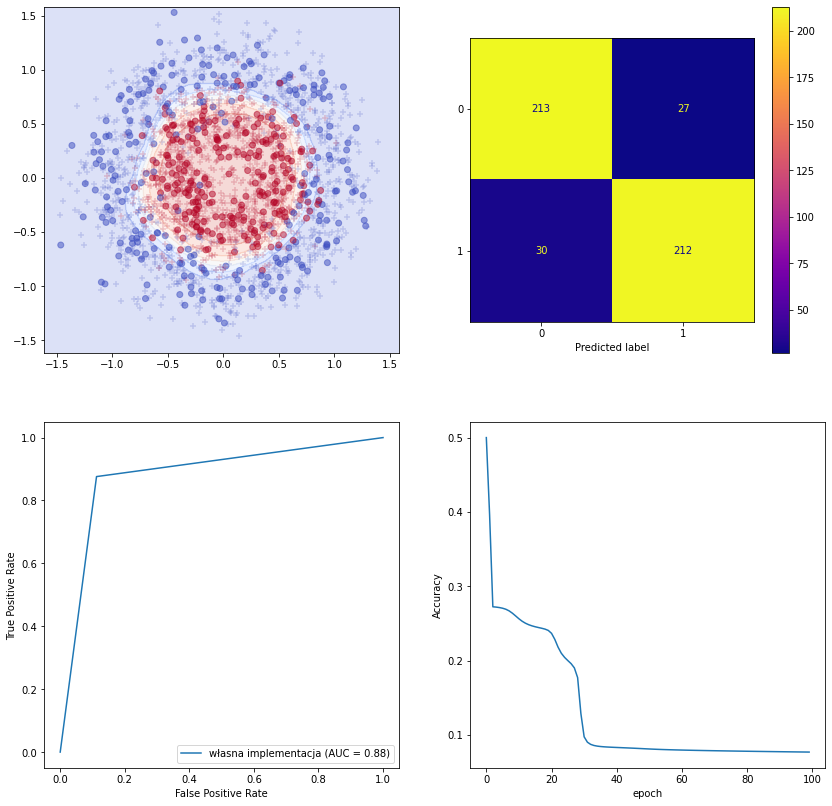

In [14]:
X, y = datasets.make_circles(noise=0.2, factor=0.5, n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network()
net.add(Linear(2, 16))
net.add(Activation())
net.add(Linear(16, 16))
net.add(Activation())
net.add(Linear(16, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)


# train
net.use(mse, mse_prime)
net.fit(X_train_new, y_train, epochs=100, learning_rate=0.1)

# test
out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])
vis(net,out, 'Sieć 3-warstwowa, 16 neuronów warstw ukrytych')

## MNIST


In [110]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [111]:
X_train_new = X_train.reshape(X_train.shape[0],1,28*28)
X_train_new.shape
X_train_new = X_train_new.astype('float32')
X_train_new /= 255
# kodowanie one hot
y_train = np_utils.to_categorical(y_train)


In [112]:
net = Network()
net.add(Linear(28*28, 100))
net.add(Activation())
net.add(Linear(100, 50))
net.add(Activation())
net.add(Linear(50, 10))
net.add(Activation())


# train
net.use(mse, mse_prime)
net.fit(X_train_new[0:1000,], y_train[0:1000,], epochs=50, learning_rate=0.1)

# test
X_test_new = X_test.reshape(X_test.shape[0],1,28**2)
X_test_new = X_test_new.astype('float32')
# X_test_new /= 255

out = net.predict(X_test_new)



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.27it/s]


In [113]:
ans = []
for v in out:
    ans.append(np.argmax(v))
ans

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [114]:
out

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([[1.,

# https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

In [106]:
class Activation(Layer):
    def __init__(self):
        self.activation = self.logistic
        self.activation_der = self.logistic_der
        
    def logistic(self, X):
        return np.tanh(X);
    
    def logistic_der(self, X):
        return 1-np.tanh(X)**2;
    
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.activation_der(self.input) * output_error